In [1]:
"""
PURPOSE: This script is used to make plots of simulated muon track hits
    in the Pixel and Strip Tracker layers. 
SYNTAX: python this_script.py
NOTES:
AUTHOR: Jake Rosenzweig
CREATED: 2020-08-20
UPDATED: 2020-08-21
"""
from ROOT import (TGraph, TCanvas, TLegend, TF1, TMultiGraph, TH1F, TPad,
                  gROOT, gStyle)
import numpy as np
from array import array

from Utils_Python.Plot_Styles_ROOT.tdrstyle_official import setTDRStyle, tdrGrid

Welcome to JupyROOT 6.12/07


In [2]:
class HitPlotOrg:
    def __init__(self, pT, position_ls):
        """Plot and fit the muon track."""
        self.pT_true = pT
        self.position_ls = position_ls 
        self.n_hits = len(position_ls)
        
        self.a_true = self.convert_pT_to_a(pT)
        self.a_fit = None
        self.a_fit_err = None
        self.d0 = None
        self.pT_fit = None
        self.y_vals = None
        self.y_vals_smear = None
        
        self.dpTOverpT = None
        self.daOvera = None
        
    def convert_pT_to_a(self, pT, q=-1, B=3.8):
        """Calculates the 'p2' parameter for a parabola (also called 'a') based on pT: 
            pT = q*B*R
            R = radius of curvature = 1/(2*a)
            
            ==> a = |q|*B / (2*pT)
            
        q : charge of the particle in units of 'e' (example: -1 e, +1 e, )
            # Recall that in HEP, the conversion is:
            # 1 e [unitless] = 1.602E-19 = (0.3 / |c|) * GeV/J
            # Here, |c| is simply the number 3E8. 
        B : magnetic field of particle 
        
        Returns `a` in cm^(-1).
        """
        return 0.3 * abs(q) * B / float(2.0 * pT * 100)
    
    def convert_a_to_pT(self, a, q=-1, B=3.8):
        """
        Converts `a` in pT, doing the reverse of convert_pT_to_a().
        Assumes a is in cm^(-1).
        Returns pT in GeV/c.
        """
        return 0.3 * abs(q) * B / float(2.0 * a * 100)
    
    def calc_daOvera(self):
        """Return (a_fit - a_true) / a_true."""
        return float(self.a_fit - self.a_true) / self.a_true
    
    def calc_dpTOverpT(self):
        """Return (pT_fit - pT_true) / pT_true."""
        return float(self.pT_fit - self.pT_true) / self.pT_true
        
    def find_parabolic_y_vals(self, a, x_arr):
        """Return the y-values, assuming a parabolic trajectory."""
        return a * x_arr**2
    
    def plot_hit_trajectory(self, leg=None, color=1, smear=False, sigma=0.01):
        """
        Draw the muon track as it hits the Pixel and Strip layers.
        Return (TGraph, TLegend) tuple.
        """
        # Add to the legend.
        if leg is None:
            leg = TLegend()
        leg_text = r"p_{T} = %.0f GeV" % self.pT_true
            
        n_pts = len(self.position_ls)
        
        # Use y = a*x^2 to model the trajectory of the muon.
        # For high pT this is reasonable. 
        # Radius of curvature goes like: R = 1 / (2*a)
        x_vals = np.array(self.position_ls)
        y_vals = self.find_parabolic_y_vals(self.a_true, x_vals)
        self.y_vals = y_vals.copy()  # self.y_vals will get smear later. 
        
        # Then convert them to array.arrays afterward.
        x_arr = array('f', x_vals)
        
        graph_title = "Hits along muon path"
        if (smear):
            graph_title += " (y-val smeared)"
            leg_text += " (y-val smeared)"
            self.y_vals_smear = self.smear_hits(sigma=sigma)
            y_arr = array('f', self.y_vals_smear)
        else:
            y_arr = array('f', y_vals)

        # Make the graph.
        gr = TGraph(n_pts, x_arr, y_arr)
        gr.SetLineColor(color)
        gr.SetLineWidth(1)
        gr.SetMarkerColor(color)
        gr.SetMarkerStyle( 21 )
        gr.SetTitle(graph_title)
        gr.GetXaxis().SetTitle('Transverse Pixel/Strip Positions [cm]')
        gr.GetYaxis().SetTitle('Distance from x-axis [cm]')
        gr.GetYaxis().SetTitleOffset(1.5)
        
        leg.AddEntry(gr, leg_text, "lp")
#         leg.SetTextColor(color)
        return gr, leg

    def smear_hits(self, sigma=0.01):
        """
        Return the y-value of each hit after adding a small Gaussian uncertainty.
        By default, sigma of Gaus is 100 um = 0.01 cm (since positions are measured in cm).
        """
        smears = np.random.normal(loc=0, scale=sigma, size=self.n_hits)
#         rng = np.random.default_rng(1)
#         smears = rng.normal(loc=0, scale=sigma, size=self.n_hits)
        return self.y_vals + smears

    def fit_hits_pol2(self, graph):
        """Return the pol2 fit parameters for a set of (x,y) coordinates.
        
        Parameters
        ----------
        graph : TGraph-like
            Graph to be fit.
            
        Returns
        -------
        fit_func : TF1
            The fitting function whose best-fit parameters are obtained from `graph`.
        """
        x_min = min(self.position_ls) 
        x_max = max(self.position_ls)
        fit_func = TF1('f1', '[0]+[1]*x+[2]*x^2', x_min, x_max)
        fit_func.SetLineColor(1)
        fit_func.SetLineWidth(2)
        fit_func.SetLineStyle(2)
        # Fit it onto a histogram `h1`:
        graph.Fit(fit_func,'S')
        # The option 'S' saves the fit results into a pointer.
        gStyle.SetOptFit(111)
        
        self.set_fit_vals(fit_func)
        
        return fit_func
    
    def set_fit_vals(self, fit_func):
        """Check that the best-fit params are reasonable and set attributes."""
        self.a_fit = fit_func.GetParameter(2)
        self.a_fit_err = fit_func.GetParError(2)
        self.d0 = fit_func.GetParameter(0)
        assert self.a_fit is not None
        assert self.a_fit_err is not None
        
        self.pT_fit = self.convert_a_to_pT(self.a_fit)
        self.dpTOverpT = self.calc_dpTOverpT()
        self.daOvera = self.calc_daOvera()

class BiasPlotter:
    def __init__(self, pT, position_ls, smear=True):
        """Toss n_toys to test the theoretical bias of da/a or dpT/pT vs. d0."""
        self.pT = pT
        self.position_ls = position_ls
        self.smear = smear
        
        # Attribute which will eventually be filled.
        self.n_toys = None
        self.d0_ls = None
        self.daOvera_ls = None
        self.dpTOverpT_ls = None

    def toss_toys(self, n_toys):
        """Make n_toys worth of muon trajectories with pT (self.pT)."""
        self.n_toys = n_toys
        d0_ls = []
        daOvera_ls = []
        dpTOverpT_ls = []
        
        for n in range(n_toys):
            hitplotorg = HitPlotOrg(pT=self.pT, position_ls=self.position_ls)
            gr_smear, leg_smear = hitplotorg.plot_hit_trajectory(smear=self.smear)
            fit_func = hitplotorg.fit_hits_pol2(gr_smear)
            # Append new values. 
            d0_ls.append(hitplotorg.d0)
            daOvera_ls.append(hitplotorg.daOvera)
            dpTOverpT_ls.append(hitplotorg.dpTOverpT)
            
        self.d0_ls = d0_ls
        self.daOvera_ls = daOvera_ls
        self.dpTOverpT_ls = dpTOverpT_ls
        
    def graph_dXOverX(self, kinem="dpTOverpT", color=4, do_fit=True):
        """Returns a plot of dX/X vs. d0."""
        assert kinem in ["dpTOverpT", "daOvera"]
        err_msg = "You have to toss some toys first! Do: `biasplotter.toss_toys(int)`"
        assert self.n_toys is not None, err_msg
        print "Making {} plot after tossing {} toys...".format(kinem, self.n_toys)
        
        y_label = r"Z#DeltaX/X"
        x_vals = np.array(self.d0_ls)
        if kinem in "dpTOverpT":
            y_label = y_label.replace("X", r"p_{T}").replace("Z", "-")
            y_vals = np.array(self.dpTOverpT_ls) * -1.0
        elif kinem in "daOvera":
            y_label = y_label.replace("X", "a").replace("Z", "")
            y_vals = np.array(self.daOvera_ls)
        graph_title = r"Bias of %s vs. d_{0} #bf{(p_{T}= %s GeV, n_{toys}= %d)}" % (y_label, self.pT, self.n_toys)
        
        # Then convert them to array.arrays afterward.
        x_arr = array('f', x_vals)
        y_arr = array('f', y_vals)
        
        # Make the graph.
        gr = TGraph(self.n_toys, x_arr, y_arr)
        gr.Draw("AP")
        gr.SetLineColor(color)
        gr.SetLineWidth(1)
        gr.SetMarkerColor(color)
#         gr.SetMarkerSize(0.05)
        gr.SetMarkerStyle(6)  # Small dot.
        gr.SetTitle(graph_title)
        gr.GetXaxis().SetTitle("d_{0} [cm] (p0 from fit)")
        gr.GetYaxis().SetTitle(y_label)
        gr.GetXaxis().SetRangeUser(-0.03, 0.03)
        gr.GetYaxis().SetRangeUser(-0.1, 0.1)
#         gr.GetYaxis().SetTitleOffset(1.5)
        # Must do 2 Draw() calls to set TGraphs properly...
#         gr.Draw("AP")
        
        if (do_fit):
            self.fit_graph_with_line(gr)
        return gr

    def fit_graph_with_line(self, graph):
        """Return a linear fit function and after fitting it to graph."""
        x_min = min(self.d0_ls) 
        x_max = max(self.d0_ls)
        fit_func = TF1('f1', '[0]+[1]*x', x_min, x_max)
        fit_func.SetLineColor(2)
        fit_func.SetLineWidth(1)
        fit_func.SetLineStyle(2)
        # Fit it onto a histogram `h1`:
        graph.Fit(fit_func,'S')
        # The option 'S' saves the fit results into a pointer.
        gStyle.SetOptFit(111)
        fit_func.Draw("same")
        
        return fit_func
        
#--- Script functions ---#
def plot_muon_hits_all_pTs(pT_ls, position_ls, smear=False):
    """
    Show one plot with all muon hits for each pT and Tracker position specified.
    
    Parameters
    ----------
    pT_ls : list
        The muon pTs whose tracks will be plotted.
    position_ls : list
        The hits along the Tracker as a radial distance from the interaction point.
        
    Returns
    -------
    mg : TMultiGraph
        Contains all the TGraphs, each of which is a muon trajectory.
    leg : TLegend
        The legend.
    c1 : TCanvas
        The drawn-on canvas.
    """
    c1 = TCanvas()
    leg = TLegend(0.2, 0.7, 0.4, 0.9)
    mg = TMultiGraph()

    for count,pT in enumerate(pT_ls, 1):
        hitplotorg = HitPlotOrg(pT=pT, position_ls=position_ls)
        gr, leg = hitplotorg.draw_hits(leg=leg, color=count, smear=smear)
        mg.Add(gr, "CP")
    mg_title = "Hits along muon path; Transverse Pixel/Strip Positions [cm];Distance from x-axis [cm]"
    mg.SetTitle(mg_title)
    mg.Draw("A")
    mg.GetXaxis().SetRangeUser(0, 120)
    # mg.GetYaxis().SetRangeUser(0, 120)
    leg.SetTextSize(0.02)
    leg.Draw("same")
    c1.Draw()
    return mg, leg, c1

def plot_smear_and_nonsmear_yvals(pT, position_ls):
    """
    Show one plot with all muon hits for each pT and Tracker position specified.
    
    Parameters
    ----------
    pT : list
        The muon pT whose track will be plotted.
    position_ls : list
        The hits along the Tracker as a radial distance from the interaction point.
        
    Returns
    -------
    mg : TMultiGraph
        Contains all the TGraphs, each of which is a muon trajectory.
    leg : TLegend
        The legend.
    c1 : TCanvas
        The drawn-on canvas.
    """
    c1 = TCanvas()
    leg = TLegend(0.2, 0.7, 0.4, 0.9)
    mg = TMultiGraph()

    hitplotorg1 = HitPlotOrg(pT=pT, position_ls=position_ls)
    hitplotorg2 = HitPlotOrg(pT=pT, position_ls=position_ls)
    gr, leg = hitplotorg1.draw_hits(leg=leg, smear=False)
    gr_smear, leg_smear = hitplotorg2.draw_hits(leg=leg, smear=True)
    mg.Add(gr, "CP")
    mg.Add(gr_smear, "CP")
    title
    x_label = "Transverse Pixel/Strip Positions [cm]"
    y_label = "Distance from x-axis [cm]"
    mg_title = r"Before and after y-val smearing (100 #mum);%s;%s" % (title, x_label, y_label)
    mg.SetTitle(mg_title)
    mg.Draw("A")
    mg.GetXaxis().SetRangeUser(0, 120)
    # mg.GetYaxis().SetRangeUser(0, 120)
    leg.SetTextSize(0.02)
    leg.Draw("same")
    c1.Draw()
    return mg, leg, c1

def set_properties():
    gROOT.SetBatch(True)
    tdrStyle = setTDRStyle()
    tdrGrid(tdrStyle, gridOn=True)

# if __name__ == '__main__':

# mg, leg, c1 = plot_muon_hits_all_pTs(pT_ls, new_pixel_pos, smear=True)

#     c1.SaveAs("/blue/avery/rosedj1/HiggsMassMeasurement/d0_Studies/plots/toy_model/muon_hits_thru_Tracker.pdf")

(<ROOT.TMultiGraph object at 0x76df490>,
 <ROOT.TLegend object ("TPave") at 0x7605d70>,
 <ROOT.TCanvas object ("c1") at 0x120f990>)

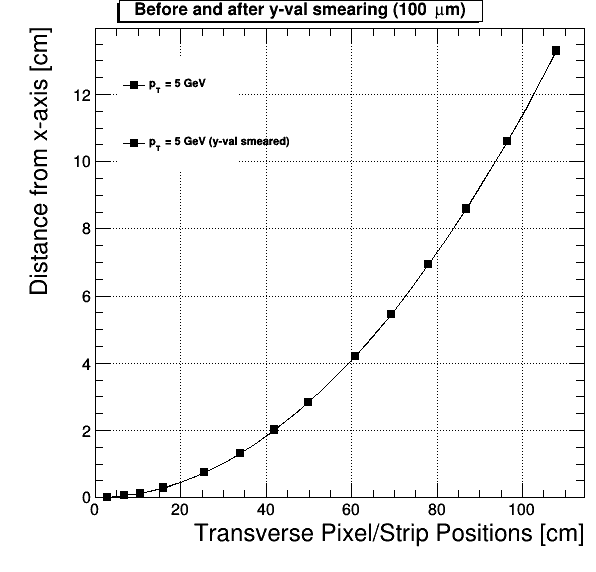

In [8]:
plot_smear_and_nonsmear_yvals(5, new_pixel_pos)

Making daOvera plot after tossing 5000 toys...


KeyboardInterrupt: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



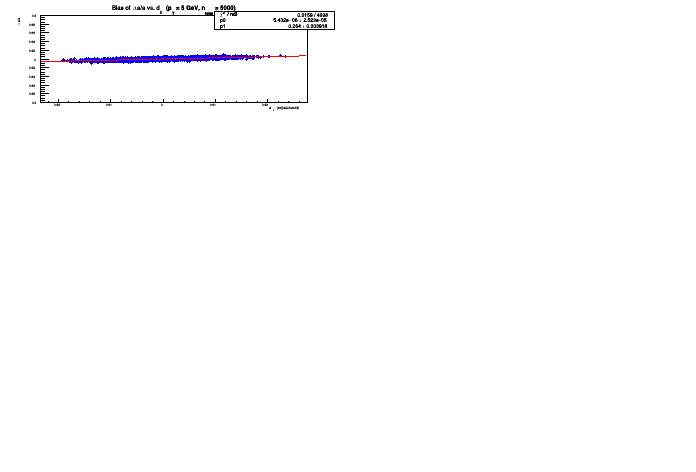

In [4]:
%%time
# set_properties()

new_pixel_pos = [2.9, 6.8, 10.5, 16.0, 25.5, 33.9, 41.9, 49.8, 60.8, 69.2, 78.0, 86.8, 96.5, 108]
pT_ls = [5, 10, 20, 30, 40, 50, 75, 100]

n_toys = 5000
c1 = TCanvas()
c1.Divide(2, 4)
biasplotter_ls = []
gr_daOvera_ls = []
gr_dpTOverpT_ls = []
for pad,pT in enumerate(pT_ls, 1):
#     if pad > 2: break
    biasplotter_ls.append( BiasPlotter(pT=pT, position_ls=new_pixel_pos) )
    biasplotter_ls[-1].toss_toys(n_toys=n_toys)

    c1.cd(pad)
    is_odd_num = ((pad + 1) % 2 == 0)
    if (is_odd_num):
        gr_daOvera_ls.append( biasplotter_ls[-1].graph_dXOverX(kinem="daOvera", color=4) )
#         gr_daOvera_ls[-1].Draw("ap")
#         line_fit_50GeV_a = biasplotter.fit_graph_with_line(gr_daOvera_vs_d0)
    else:
        gr_dpTOverpT_ls.append( biasplotter_ls[-1].graph_dXOverX(kinem="dpTOverpT", color=4) )
#         gr_dpTOverpT_ls[-1].Draw("ap")
#         line_fit_50GeV_pT = biasplotter.fit_graph_with_line(gr_dpTOverpT_vs_d0)
    c1.Draw()
c1.SaveAs("/blue/avery/rosedj1/HiggsMassMeasurement/d0_Studies/Toy_Model/plots/test_another_few_pTs.pdf")

In [ ]:
%%time
# set_properties()
outfile_path = "/blue/avery/rosedj1/HiggsMassMeasurement/d0_Studies/Toy_Model/plots/test_twoperpage.pdf"
new_pixel_pos = [2.9, 6.8, 10.5, 16.0, 25.5, 33.9, 41.9, 49.8, 60.8, 69.2, 78.0, 86.8, 96.5, 108]
pT_ls = [5, 10, 20, 30, 40, 50, 75, 100]

n_toys = 50
c1 = TCanvas()
c1.Divide(2, 4)
biasplotter_ls = []
gr_daOvera_ls = []
gr_dpTOverpT_ls = []
c1.Print(outfile_path + "[")
# for pad,pT in enumerate(pT_ls, 1):

for pT in pT_ls:
    pad = TPad("pad_%s" % pT, "A pad with a hist", 0.03, 0.02, 0.97, 0.57)
    pad.Divide(2,1)
    pad.cd(1)
    biasplotter_ls.append( BiasPlotter(pT=pT, position_ls=new_pixel_pos) )
    biasplotter_ls[-1].toss_toys(n_toys=n_toys)

    gr_daOvera_ls.append( biasplotter_ls[-1].graph_dXOverX(kinem="daOvera", color=4) )
    pad.cd(2)
    gr_dpTOverpT_ls.append( biasplotter_ls[-1].graph_dXOverX(kinem="dpTOverpT", color=4) )
    c1.Draw()
    c1.Print(outfile_path)

c1.Print(outfile_path + "]")

Warning in <TROOT::Append>: Replacing existing TH1: h_d0 (Potential memory leak).


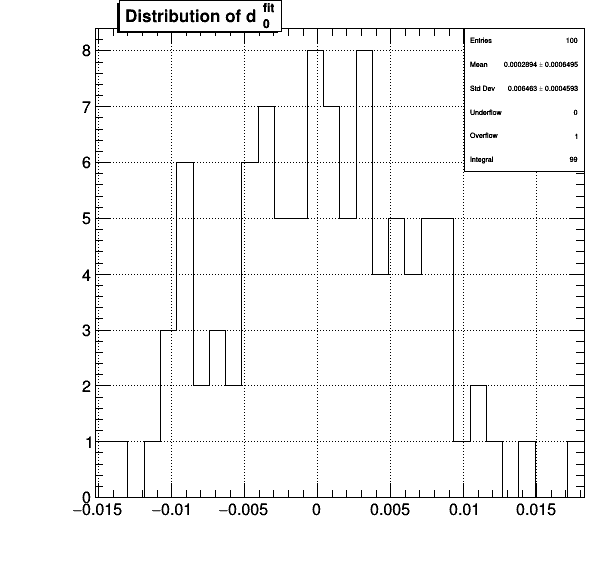

In [14]:
d0_vals = biasplotter_5GeV.d0_ls
h_d0 = TH1F("h_d0", "Distribution of d_{0}^{fit}", 30, min(d0_vals), max(d0_vals))
for num in d0_vals:
    h_d0.Fill(num)
c1 = TCanvas()
h_d0.Draw("hist")
gStyle.SetOptStat("iouRMe")
c1.Draw()